In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline
import matplotlib
import contextily as cx
import math
import numpy as np
import pandas as pd

## Visualizing results of WRF-driven AutoBEM
### And comparing it to NASA POWER (NP) driven AutoBEM

The outline of this notebook gets the building-specific data and stores it in `gdf`
After some elementary visualization of it, it is aggregated to the wrf cells and stored in `cells_gdf`
The geometry on each of these is the same (the centroid of the wrf cell), but `cells_gdf` is just aggregated while `gdf` is not (`gdf` has roughly 1.5 million rows)

Some key findings are presented below, namely an urban-rural split between WRF and NP for many variables. Most variables are somewhat normally distributed around 0% change, but this split is seen when plotted on a map. The surface outside heat emission and anthropogenic emission variables are both drastically lower, however, normally distributed around -20%.

This urban-rural split may be caused by not just urban heat island etc, but higher number of buildings per grid cell the closer you get to central phoenix, so changes in energy usage are more pronounced.

In [2]:
# read in all building results and define what Phoenix metro is
gdf = gpd.read_file('building_results', use_arrow=True)
from shapely.geometry import Polygon
bounds = Polygon([(-113, 34),(-113, 32.8),(-111.2, 32.8),(-111.2, 34)])

In [8]:
# define a rudimentary percent change
def percent_change(col1,col2):
        return ((col2 - col1) / col1) * 100


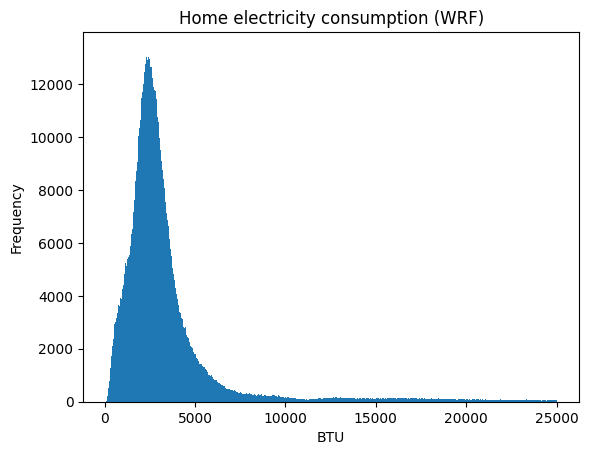

6832.885233783862


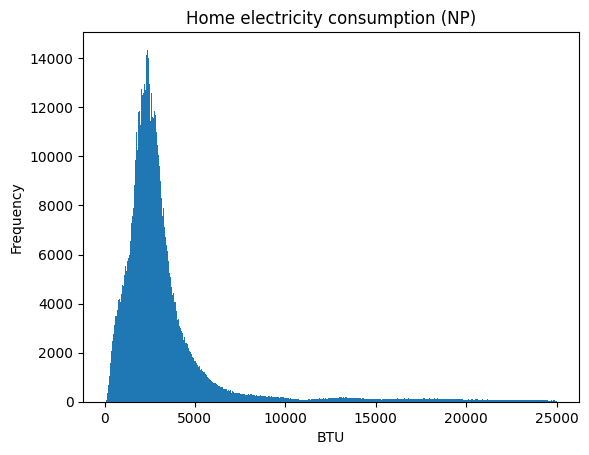

6794.418681582761


In [9]:
# plot home electricity consumption from wrf and from np just to show what kind of data we're dealing with
# this is for EACH BUILDING
ax = gdf[gdf['Electricit'] < 25000]['Electricit'].plot.hist(bins=int(np.sqrt(len(gdf.index))-200))
ax.set_title('Home electricity consumption (WRF)')
ax.set_xlabel('BTU')
plt.show()
print(gdf['Electricit'].mean())
ax = gdf[gdf['Electric_1'] < 25000]['Electric_1'].plot.hist(bins=int(np.sqrt(len(gdf.index))-200))
ax.set_title('Home electricity consumption (NP)')
ax.set_xlabel('BTU')
plt.show()
print(gdf['Electric_1'].mean())

In [10]:
# aggregate into grid cells
foo = gdf.groupby('geometry').sum().reset_index()
cells_gdf = gpd.GeoDataFrame(foo, geometry=foo['geometry'])

16535
20669


<Axes: >

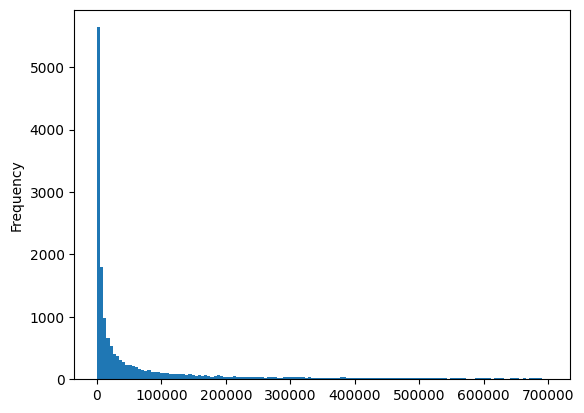

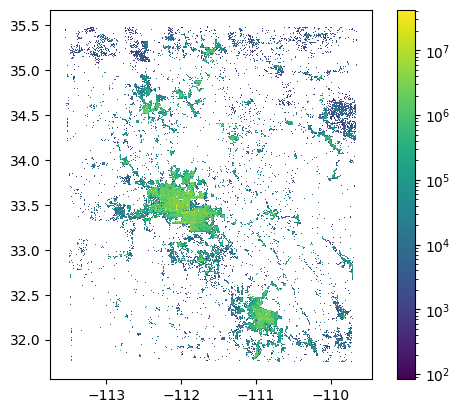

In [11]:
cells_gdf[cells_gdf['Electricit'] < 700000]['Electricit'].plot.hist(bins=int(np.sqrt(len(cells_gdf.index))))
print((cells_gdf['Electricit'] < 700000).sum())
print((cells_gdf['Electricit'] > 0).sum())

cells_gdf.plot(column='Electricit', legend=True, norm=matplotlib.colors.LogNorm(vmin=cells_gdf['Electricit'].min(), vmax=cells_gdf['Electricit'].max()))

(cells_gdf[f'{key}_change'] > 1500).sum()=818
(cells_gdf[f'{key}_change'] < -1500).sum()=0


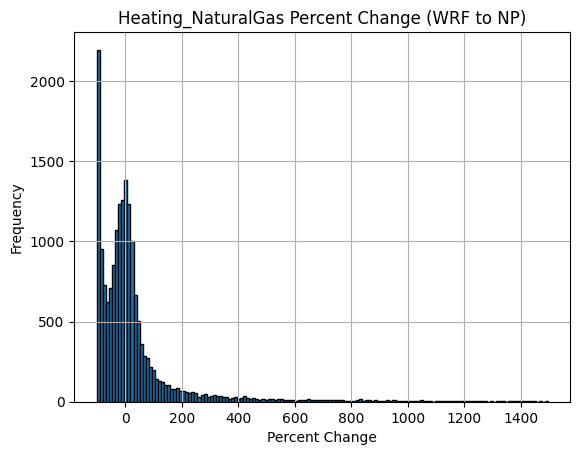

(cells_gdf[f'{key}_change'] > 1500).sum()=0
(cells_gdf[f'{key}_change'] < -1500).sum()=0


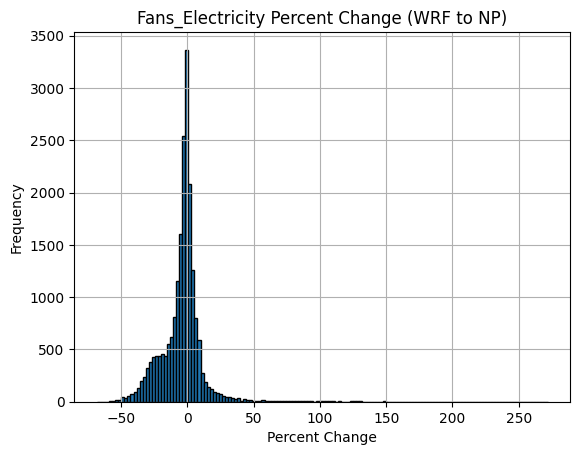

(cells_gdf[f'{key}_change'] > 1500).sum()=0
(cells_gdf[f'{key}_change'] < -1500).sum()=0


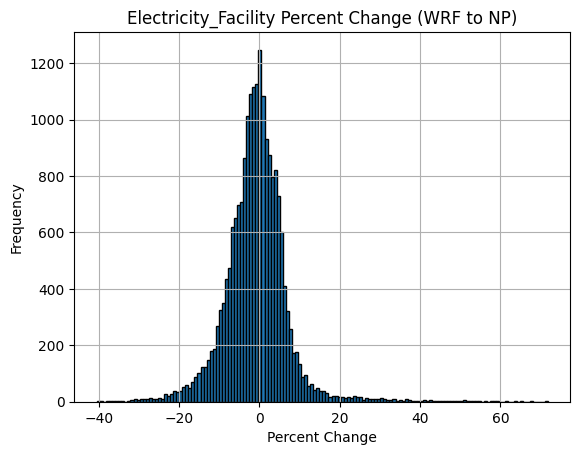

(cells_gdf[f'{key}_change'] > 1500).sum()=0
(cells_gdf[f'{key}_change'] < -1500).sum()=0


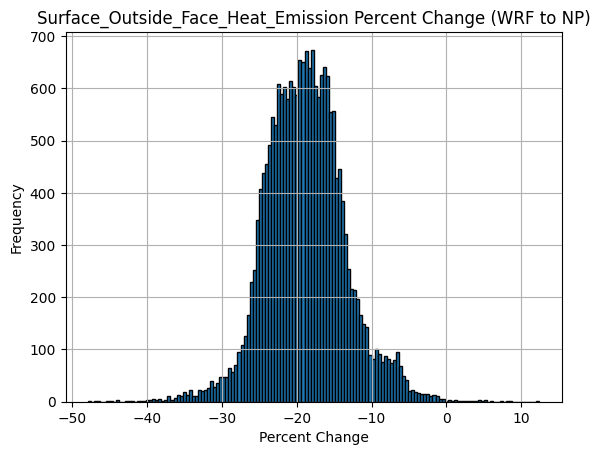

(cells_gdf[f'{key}_change'] > 1500).sum()=0
(cells_gdf[f'{key}_change'] < -1500).sum()=0


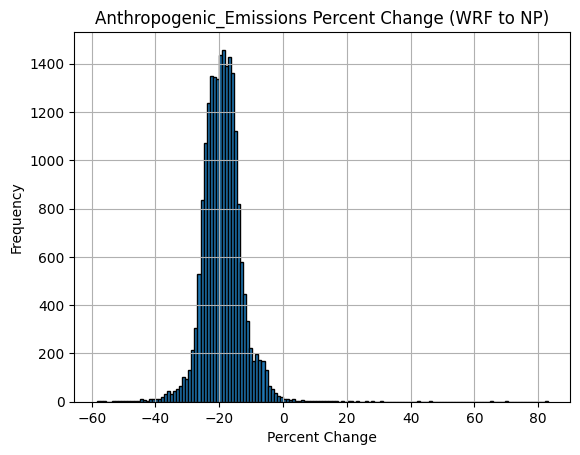

(cells_gdf[f'{key}_change'] > 1500).sum()=1
(cells_gdf[f'{key}_change'] < -1500).sum()=0


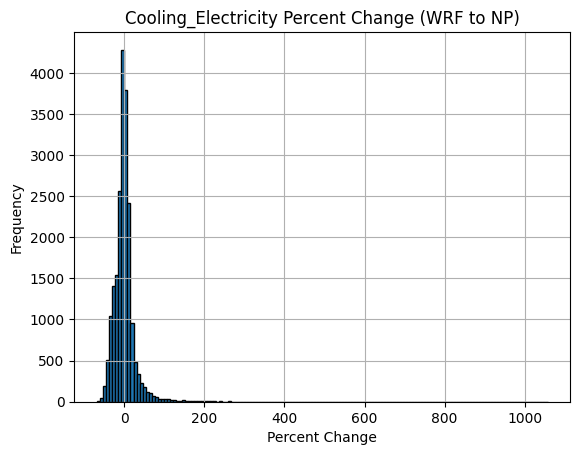

(cells_gdf[f'{key}_change'] > 1500).sum()=387
(cells_gdf[f'{key}_change'] < -1500).sum()=0


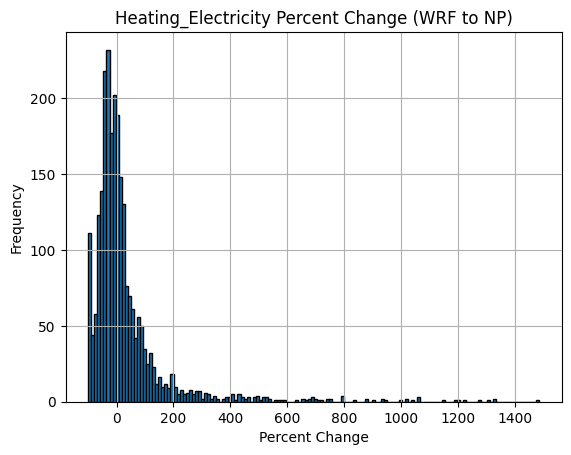

(cells_gdf[f'{key}_change'] > 1500).sum()=761
(cells_gdf[f'{key}_change'] < -1500).sum()=0


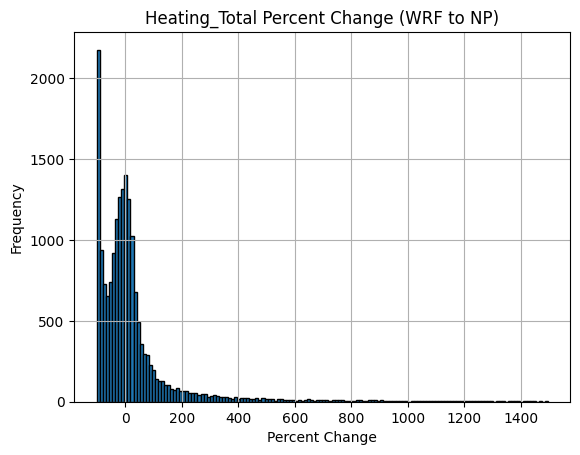

(cells_gdf[f'{key}_change'] > 1500).sum()=179
(cells_gdf[f'{key}_change'] < -1500).sum()=220


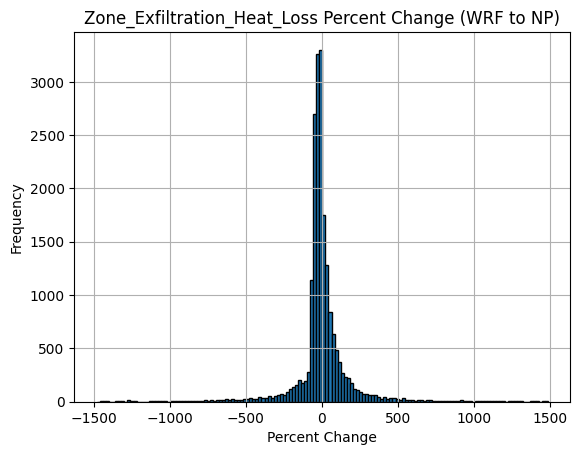

In [12]:
# plot a host of variables that have some meaning and their percent changes from WRF to NP
# many outliers are removed

cols_dict = {
    'Heating_NaturalGas': ('Heating_Na', 'Heating__2'),
    'Fans_Electricity': ('Fans_Elect', 'Fans_Ele_1'),
    'Electricity_Facility': ('Electricit', 'Electric_1'),
    'Surface_Outside_Face_Heat_Emission': ('Surface_Ou', 'Surface__1'),
    'Anthropogenic_Emissions': ('Anthropoge', 'Anthropo_1'),
    'Cooling_Electricity': ('Cooling_El', 'Cooling__1'),
    'Heating_Electricity': ('Heating_El', 'Heating__1'),
    'Heating_Total': ('Heating_To', 'Heating__3'),
    'Zone_Exfiltration_Heat_Loss': ('Zone_Exfil', 'Zone_Exf_1'),
}

for key, val in cols_dict.items():
    cells_gdf[f'{key}_change'] = percent_change(cells_gdf[val[0]], cells_gdf[val[1]])
    print(f"{(cells_gdf[f'{key}_change'] > 1500).sum()=}")
    print(f"{(cells_gdf[f'{key}_change'] < -1500).sum()=}")
    # [(cells_gdf[f'{key}_change'] < 100) & (cells_gdf[f'{key}_change'] > -100)]
    ax = cells_gdf[(cells_gdf[f'{key}_change'] < 1500) & (cells_gdf[f'{key}_change'] > -1500)][f'{key}_change'].replace([np.inf, -np.inf], np.nan).dropna().plot.hist(edgecolor='black',
                                                                                                      bins=math.floor(
                                                                                                          math.sqrt(
                                                                                                              len(cells_gdf.index))) + 5)
    ax.set_title(f'{key} Percent Change (WRF to NP)')
    ax.set_xlabel('Percent Change')
    ax.grid()
    plt.show()



### Rural vs urban split

Here we can see the rural vs urban split in many variables and their percent changes. If WRF is the "more accurate" weather, then we can view this as how NP discrepancies differ along different variables, ie a negative value means that NP is lower than real and positive means it is higher than real.

* Heating natural gas: NP overestimates urban, underestimates rural
* Fan electricity: NP underestimates urban, overestimates rural
* Total electricity: NP underestimates urban, overestimates rural
* Surface outside heat emission: NP underestimates both urban and rural
* Anthropogenic emission: NP underestimates both urban and rural
* Cooling electricity: NP underestimates urban, overestimates rural
* Heating total: NP overestimates urban, underestimates rural


Note: since one or two variables have relatively small values, percent changes may be exaggerated

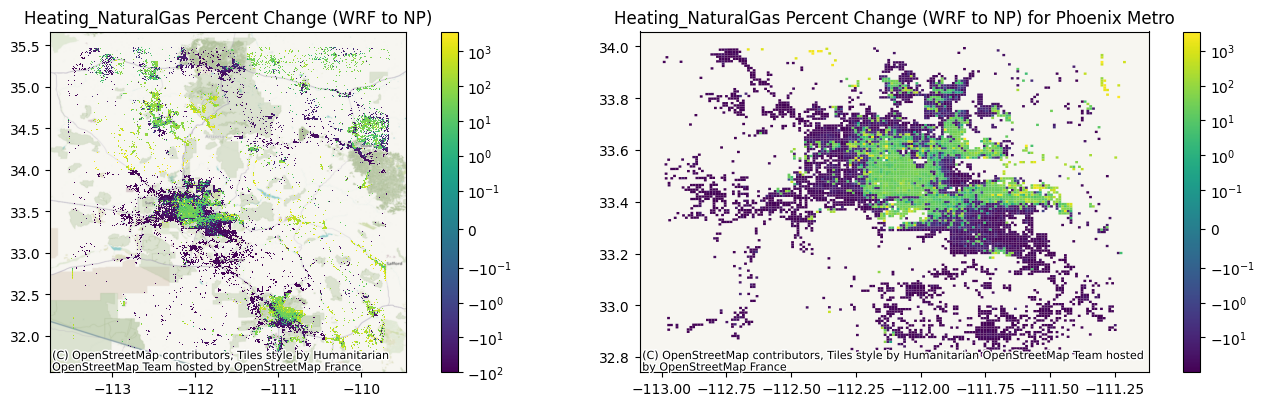

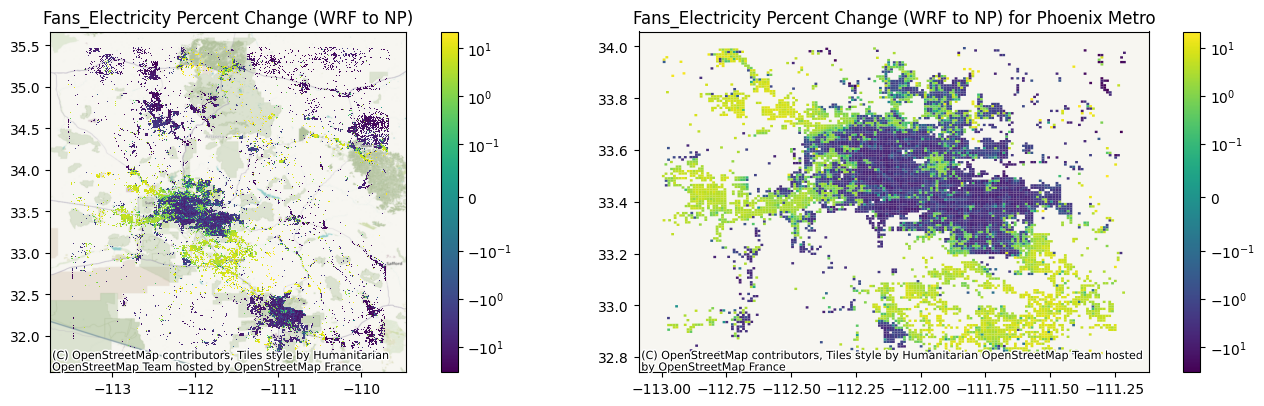

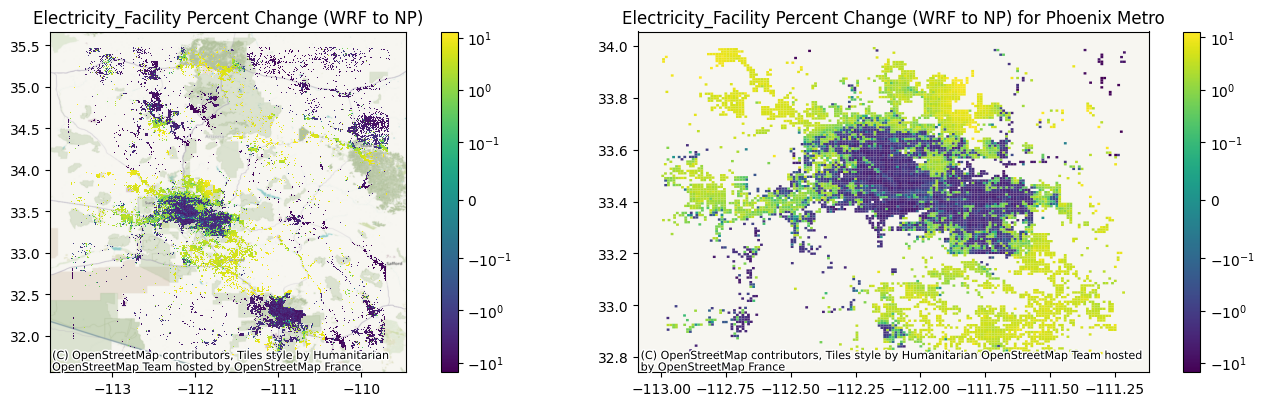

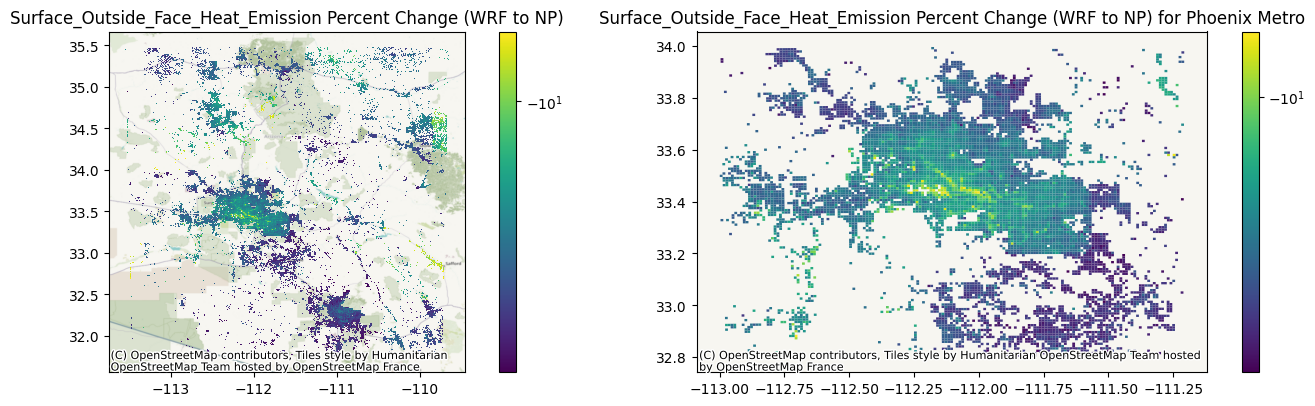

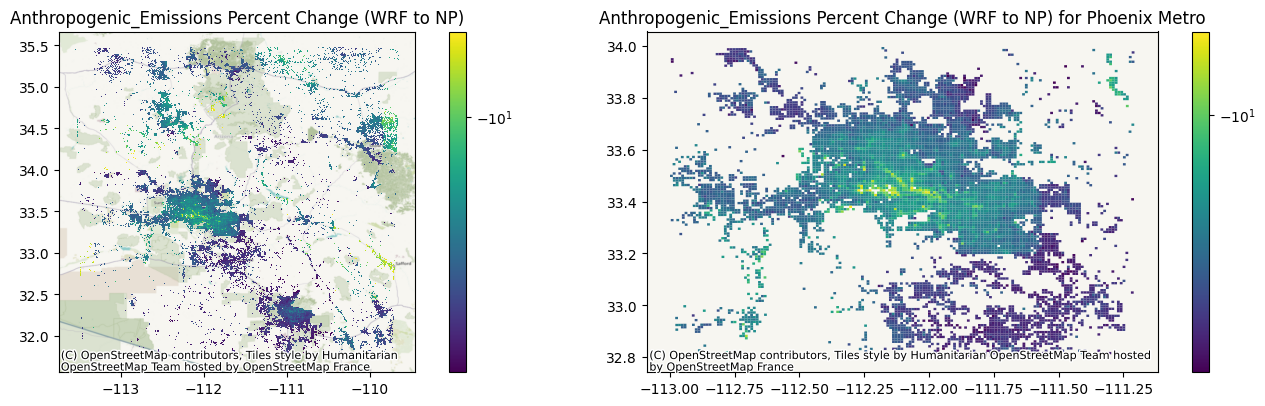

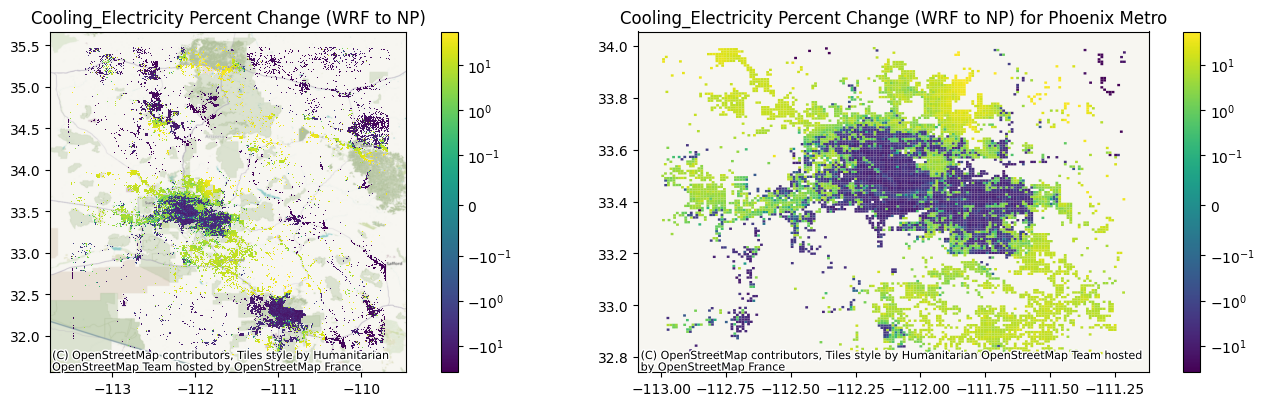

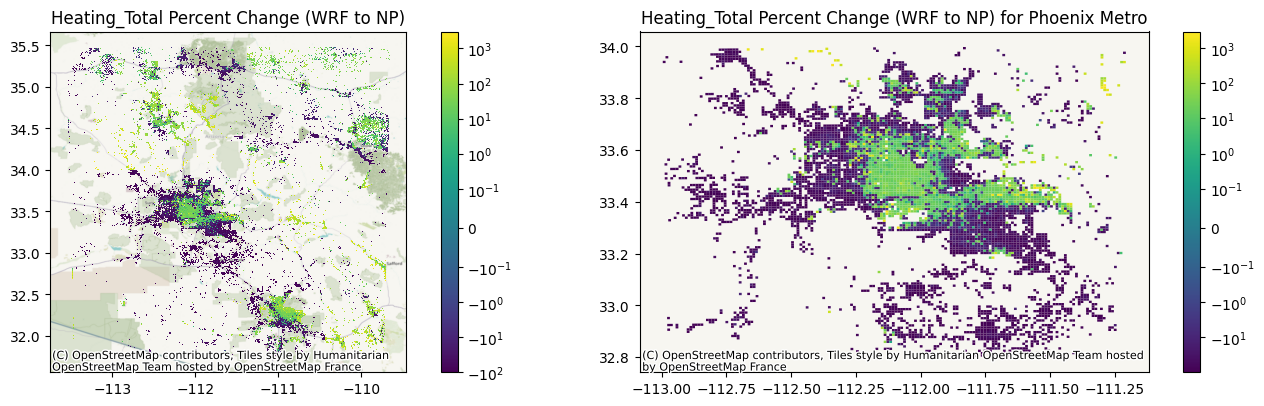

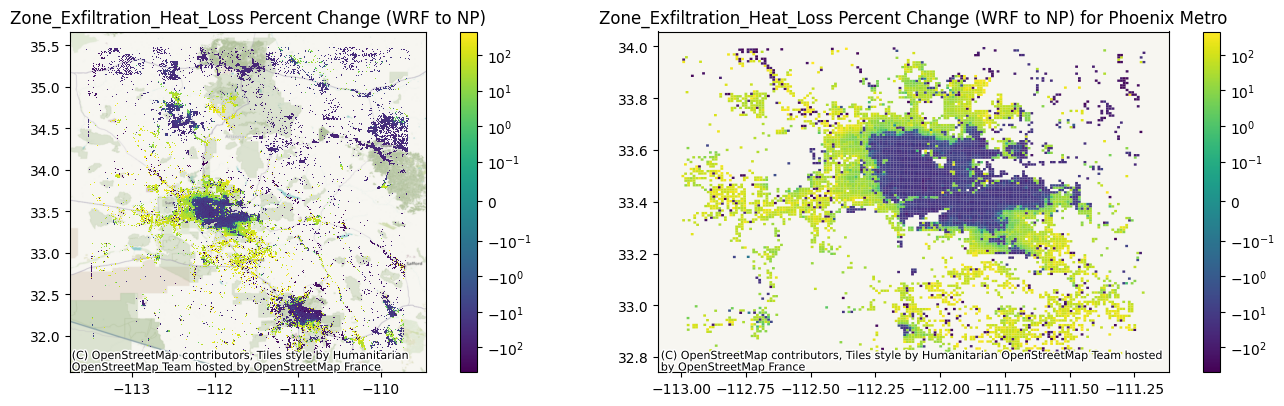

In [19]:
cols_dict = {  # get rid of heating electricity. too many zeroes for percentages to play nice. maybe we can do totals later todo
    'Heating_NaturalGas': ('Heating_Na', 'Heating__2'),
    'Fans_Electricity': ('Fans_Elect', 'Fans_Ele_1'),
    'Electricity_Facility': ('Electricit', 'Electric_1'),
    'Surface_Outside_Face_Heat_Emission': ('Surface_Ou', 'Surface__1'),
    'Anthropogenic_Emissions': ('Anthropoge', 'Anthropo_1'),
    'Cooling_Electricity': ('Cooling_El', 'Cooling__1'),
    'Heating_Total': ('Heating_To', 'Heating__3'),
    'Zone_Exfiltration_Heat_Loss': ('Zone_Exfil', 'Zone_Exf_1'),
}

for key, val in list(cols_dict.items()):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 4))
    fig.tight_layout()
    series = cells_gdf[f'{key}_change']
    lower_quantile = series.quantile(q=.03, interpolation='higher')
    upper_quantile = series.quantile(q=.97, interpolation='lower')
    cells_gdf[(series > lower_quantile) & (series < upper_quantile)].plot(column=f'{key}_change', ax=ax1, legend=True, norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=lower_quantile, vmax=upper_quantile))
    ax1.set_title(f'{key} Percent Change (WRF to NP)')
    cx.add_basemap(ax1, crs="epsg:4326")
    
    phx_tmp = cells_gdf[(cells_gdf.within(bounds)) & (series > lower_quantile) & (series < upper_quantile)]
    phx_tmp.plot(column=f'{key}_change', ax=ax2, legend=True, norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=phx_tmp[f'{key}_change'].min(), vmax=phx_tmp[f'{key}_change'].max()))
    ax2.set_title(f'{key} Percent Change (WRF to NP) for Phoenix Metro')
    
    cx.add_basemap(ax2, crs="epsg:4326", zoom=1)
    
    plt.show()


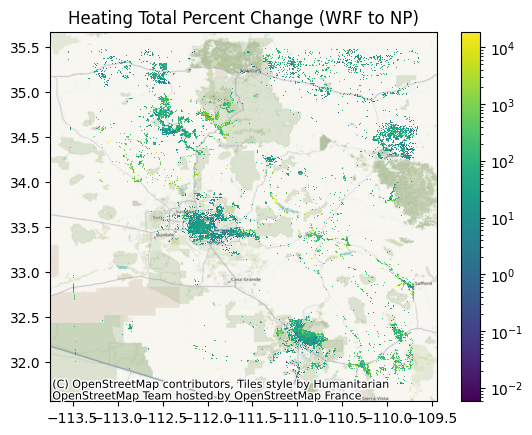

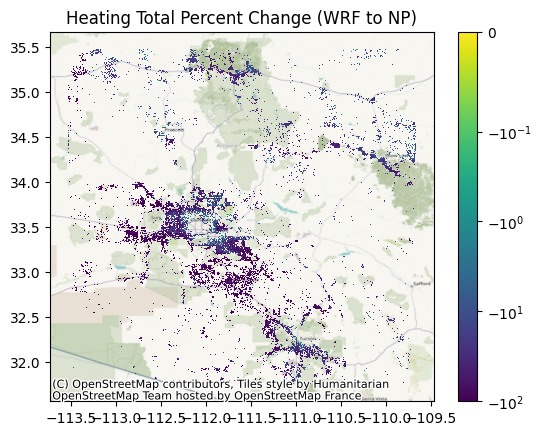

In [20]:
# an elementary map of heating total change percent that is positive and negative
# shows more clearly the distribution against phoenix itself

bar = cells_gdf['Heating_Total_change'].replace([np.inf, -np.inf], np.nan).dropna()

foo = bar[(bar > 0) & (bar < 20_000)]
ax = cells_gdf[(cells_gdf['Heating_Total_change'] > 0) & (cells_gdf['Heating_Total_change'] < 15_000)].plot(column='Heating_Total_change', legend=True, norm=matplotlib.colors.LogNorm(vmin=foo.min(), vmax=foo.max()))
cx.add_basemap(ax, crs="epsg:4326")
ax.set_title('Heating Total Percent Change (WRF to NP)')
plt.show()

foo = bar[(bar < 0)]
ax = cells_gdf[(cells_gdf['Heating_Total_change'] < 0)].plot(column='Heating_Total_change', legend=True, norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=foo.min(), vmax=0))
ax.set_title('Heating Total Percent Change (WRF to NP)')
cx.add_basemap(ax, crs="epsg:4326")
plt.show()

In [3]:
# now i want to compare wrf to np. see what we actually really changed in terms of inputs to energyplus

# get np stuff
import os
np_epws = os.listdir('AZ_NP_EPW')
np_epws.sort()
np_epws = [os.path.join('AZ_NP_EPW', x) for x in np_epws]
cols = [0,1,2,3,4,6,7,8,9,12,14,15,20,21,22]
names = ['!Year', 'Month', 'Day', 'Hour', 'Minute', 'Dry bulb temperature {C}', 
         'Dew point temperature {C}', 'Relative Humidity {%}', 'Atmospheric Pressure {Pa}',
         'Horizontal Infrared Radiation Intensity from Sky {Wh/m2}', 'Direct Normal Radiation {Wh/m2}',
         'Diffuse Horizontal Radiation {Wh/m2}', 'Wind Direction {deg}', 'Wind Speed {m/s}', 'Total Sky Cover {.1}']
np_dfs = [pd.read_csv(x, header=None, skiprows=3265, nrows=384, usecols=cols, names=names) for x in np_epws]
counties = gpd.read_file('supplemental_materials/az_counties').to_crs('epsg:4326')
counties['NAME'] = counties['NAME'].str.title().str.replace(' ', '_')
counties.sort_values(by=['NAME'], inplace=True)
for i in range(len(counties)):
    np_dfs[i]['geometry'] = [counties.iloc[i]['geometry']] * len(np_dfs[i].index)
np_gdf = gpd.GeoDataFrame(pd.concat(np_dfs))
np_gdf

!Year  Month  Day  Hour  Minute  Dry bulb temperature {C}  \
0     2020      5   15    18       0                     21.79   
1     2020      5   15    19       0                     19.76   
2     2020      5   15    20       0                     15.33   
3     2020      5   15    21       0                     13.94   
4     2020      5   15    22       0                     12.94   
..     ...    ...  ...   ...     ...                       ...   
379   2020      5   31    13       0                     35.20   
380   2020      5   31    14       0                     36.27   
381   2020      5   31    15       0                     37.09   
382   2020      5   31    16       0                     37.37   
383   2020      5   31    17       0                     37.00   

     Dew point temperature {C}  Relative Humidity {%}  \
0                        -2.13                  19.94   
1                        -1.10                  24.50   
2                         0.43                  36.12   
3                         0.39                  39.44   
4                         0.31                  41.88   
..                         ...                    ...   
379                       3.50                  13.81   
380                       2.73                  12.25   
381                       2.04                  11.12   
382                       1.41                  10.50   
383                       0.97                  10.38   

     Atmospheric Pressure {Pa}  \
0                      79567.0   
1                      79588.0   
2                      79628.0   
3                      79676.0   
4                      79717.0   
..                         ...   
379                    99284.0   
380                    99207.0   
381                    99120.0   
382                    99040.0   
383                    98987.0   

     Horizontal Infrared Radiation Intensity from Sky {Wh/m2}  \
0                                               290.52          
1                                               283.48          
2                                               278.73          
3                                               275.30          
4                                               271.80          
..                                                 ...          
379                                             378.38          
380                                             384.02          
381                                             384.85          
382                                             388.12          
383                                             381.00          

     Direct Normal Radiation {Wh/m2}  Diffuse Horizontal Radiation {Wh/m2}  \
0                             806.20                                 53.85   
1                             516.34                                 34.46   
2                               0.00                                  0.00   
3                               0.00                                  0.00   
4                               0.00                                  0.00   
..                               ...                                   ...   
379                           938.69                                 83.82   
380                           935.41                                101.87   
381                           946.48                                 88.21   
382                           888.11                                101.91   
383                           861.45                                 85.80   

     Wind Direction {deg}  Wind Speed {m/s}  Total Sky Cover {.1}  \
0                  277.00              6.02                  0.13   
1                  283.36              4.53                  0.06   
2                  291.36              3.24                  0.06   
3                  297.88              3.21                  0.05   
4                  302.34              3.12            

In [4]:
wrf_gdf = gpd.read_file('./all_conus_epws', use_arrow=True)

<Axes: >

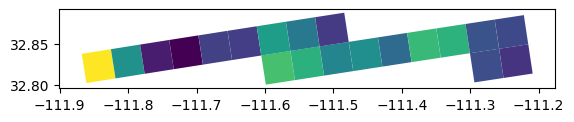

In [7]:
a = wrf_gdf[(wrf_gdf['Day'] == 16) & (wrf_gdf['Hour'] == 15) & (wrf_gdf.within(bounds))]
# a.plot(column='Dew point')
a.iloc[0:20].plot(column='Dew point')

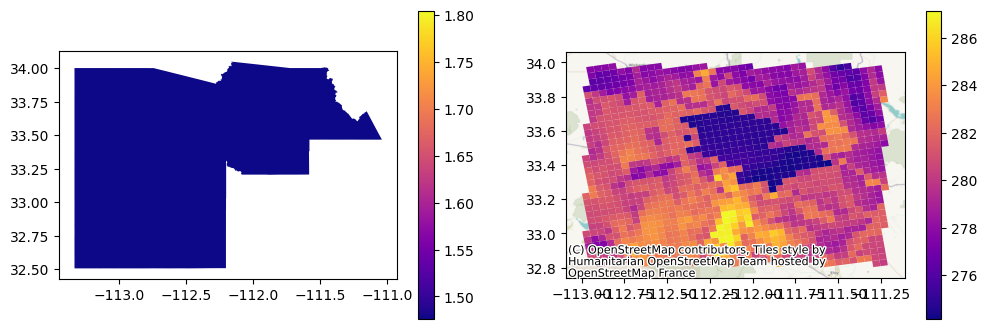

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

a = counties.loc[counties['NAME'] == 'Maricopa'].geometry
np_plot_data = np_gdf[(np_gdf['Day'] == 16) & (np_gdf['Hour'] == 15) & (np_gdf['geometry'] == a.values[0])]

wrf_plot_data = wrf_gdf[(wrf_gdf['Day'] == 16) & (wrf_gdf['Hour'] == 15) & (wrf_gdf.within(bounds)) & (wrf_gdf['Dew point'] < 10)]

my_vmin = min(np_plot_data['Dew point temperature {C}'].min(), wrf_plot_data['Dew point'].min())-.5
my_vmax = min(np_plot_data['Dew point temperature {C}'].max(), wrf_plot_data['Dew point'].max())+.5

np_plot_data.plot(ax=ax1, column='Dew point temperature {C}', cmap='plasma', vmin=my_vmin, vmax=my_vmax)

wrf_plot_data.plot(ax=ax2, legend=True, column='Dew point', cmap='plasma', vmin=my_vmin, vmax=my_vmax)
cx.add_basemap(ax2, crs="epsg:4326")



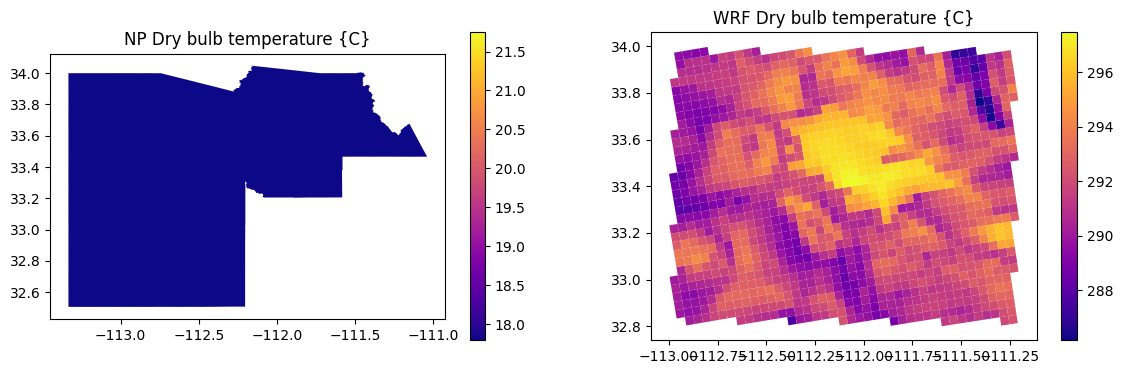

60    19.77
Name: Dry bulb temperature {C}, dtype: float64
292.19509796887155


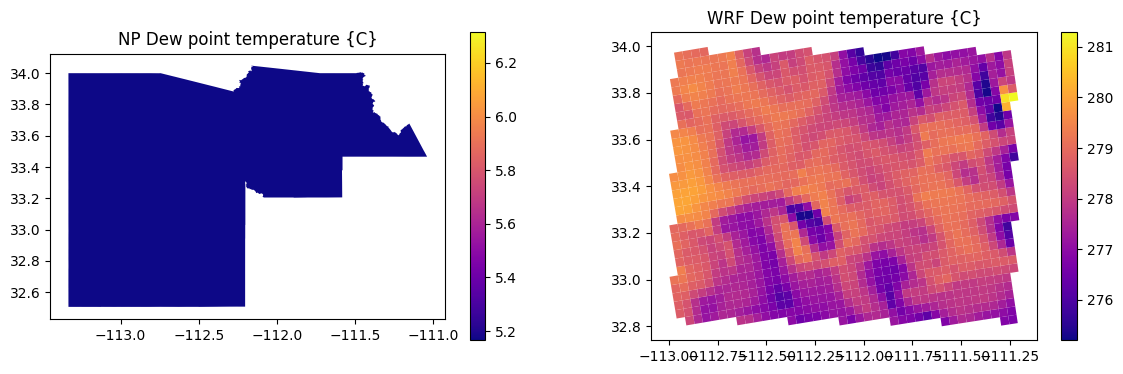

60    5.74
Name: Dew point temperature {C}, dtype: float64
278.1618863346303


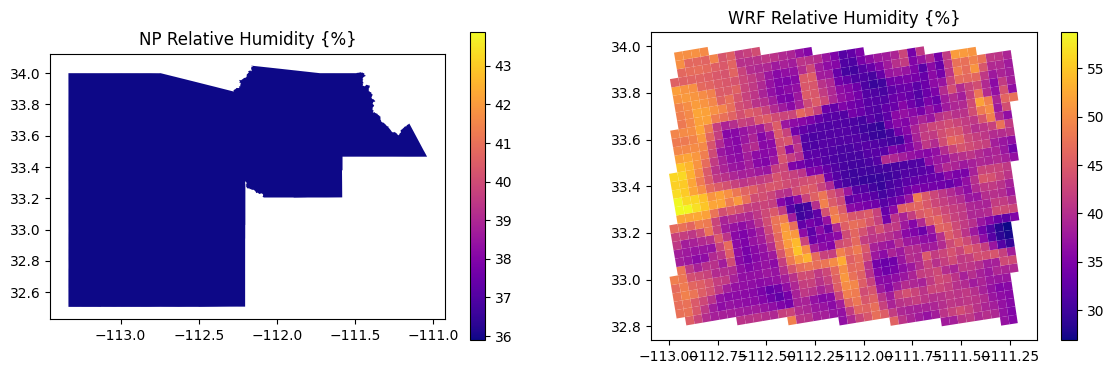

60    39.88
Name: Relative Humidity {%}, dtype: float64
40.05610478210117


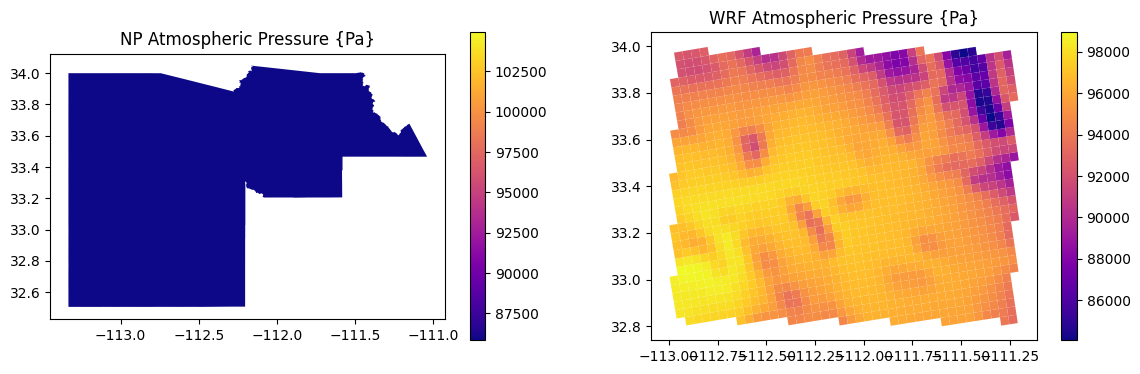

60    95379.0
Name: Atmospheric Pressure {Pa}, dtype: float64
95166.02680622568


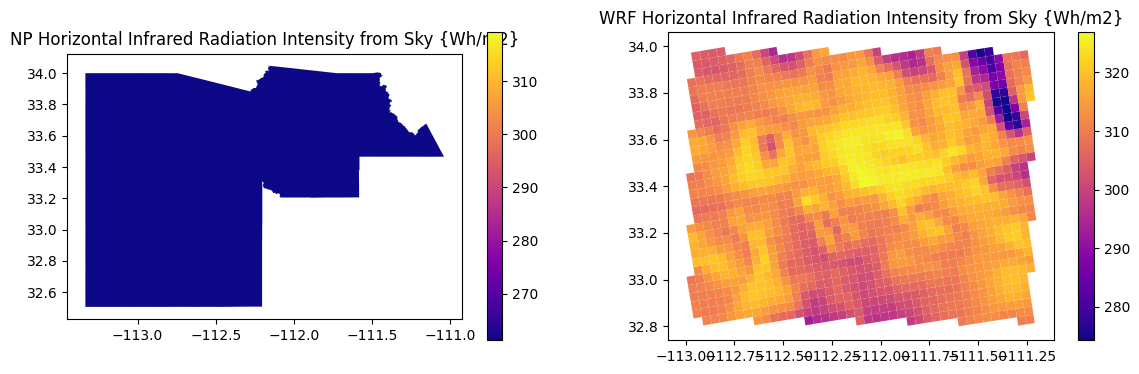

60    290.23
Name: Horizontal Infrared Radiation Intensity from Sky {Wh/m2}, dtype: float64
312.4903436575876


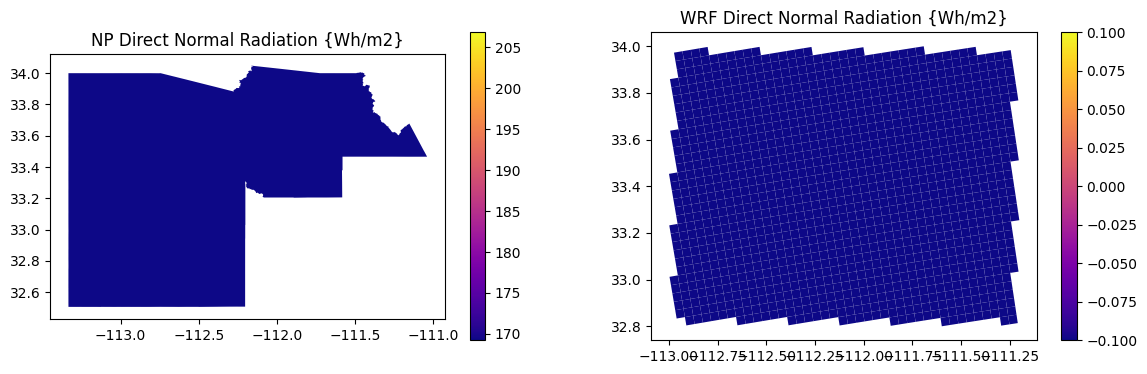

60    188.02
Name: Direct Normal Radiation {Wh/m2}, dtype: float64
0.0


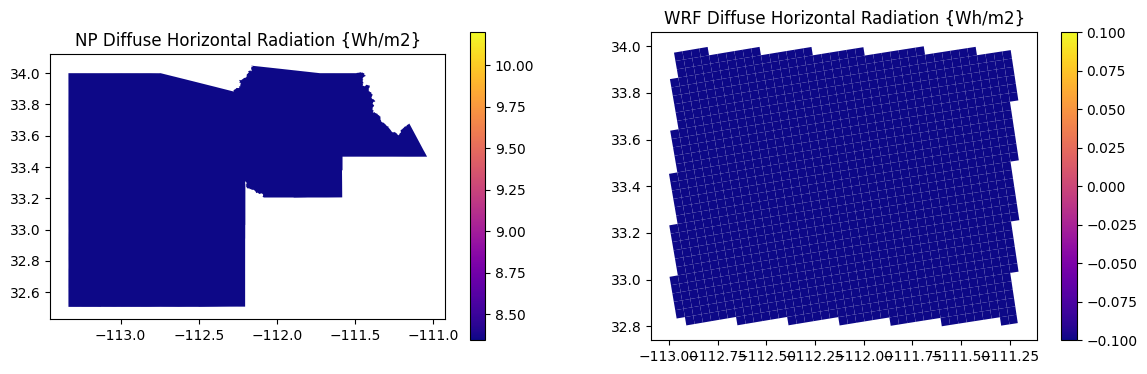

60    9.27
Name: Diffuse Horizontal Radiation {Wh/m2}, dtype: float64
0.0


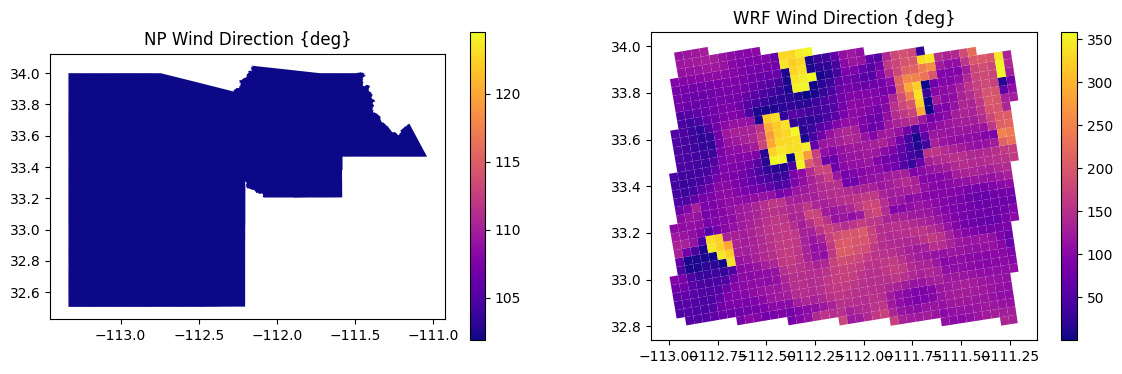

60    113.2
Name: Wind Direction {deg}, dtype: float64
117.96815715224902


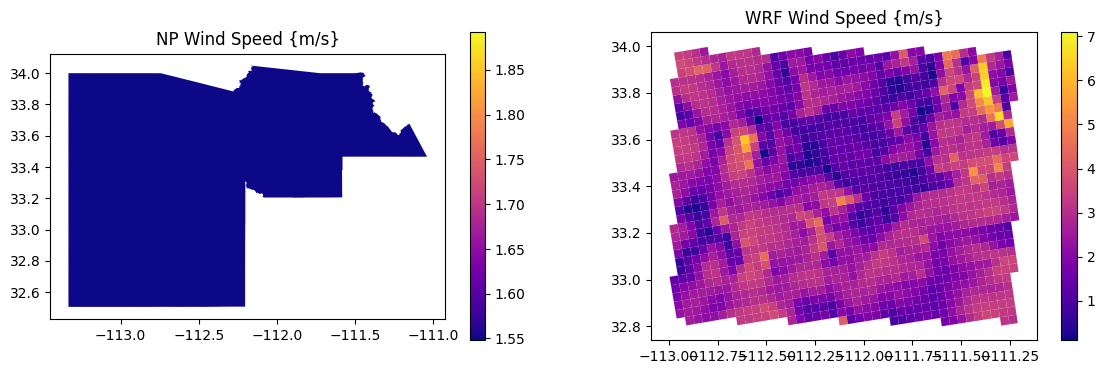

60    1.72
Name: Wind Speed {m/s}, dtype: float64
2.319343038898055


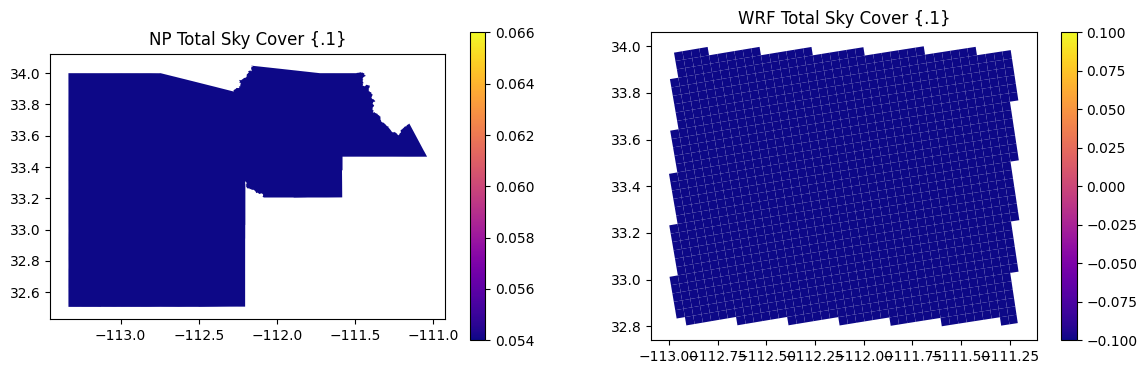

60    0.06
Name: Total Sky Cover {.1}, dtype: float64
0.0


In [17]:
for np_col, wrf_col in zip(np_gdf.columns[5:-1], wrf_gdf.columns[5:-1]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    
    a = counties.loc[counties['NAME'] == 'Maricopa'].geometry
    np_plot_data = np_gdf[(np_gdf['Day'] == 18) & (np_gdf['Hour'] == 15) & (np_gdf['geometry'] == a.values[0])]
    wrf_plot_data = wrf_gdf[(wrf_gdf['Day'] == 18) & (wrf_gdf['Hour'] == 15) & (wrf_gdf.within(bounds))]
    
    my_vmin = min(np_plot_data[np_col].min(), wrf_plot_data[wrf_col].min())-1
    my_vmax = min(np_plot_data[np_col].max(), wrf_plot_data[wrf_col].max())+1
    
    np_plot_data.plot(ax=ax1, column=np_col, cmap='plasma', vmin=my_vmin, vmax=my_vmax)
    ax1.set_title(f'NP {np_col}')
    
    wrf_plot_data.plot(ax=ax2, column=wrf_col, cmap='plasma', vmin=my_vmin, vmax=my_vmax)
    # cx.add_basemap(ax2, crs="epsg:4326")
    ax2.set_title(f'WRF {np_col}')
    plt.show()
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')


    print(np_plot_data[np_col])
    print(wrf_plot_data[wrf_col].mean())


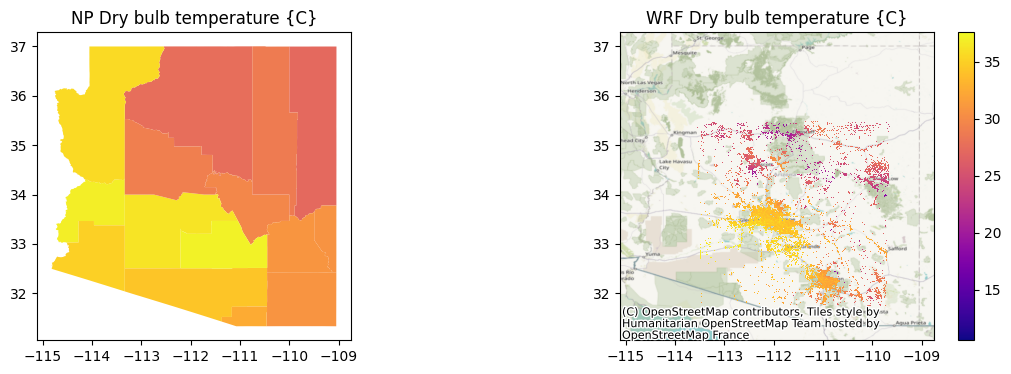

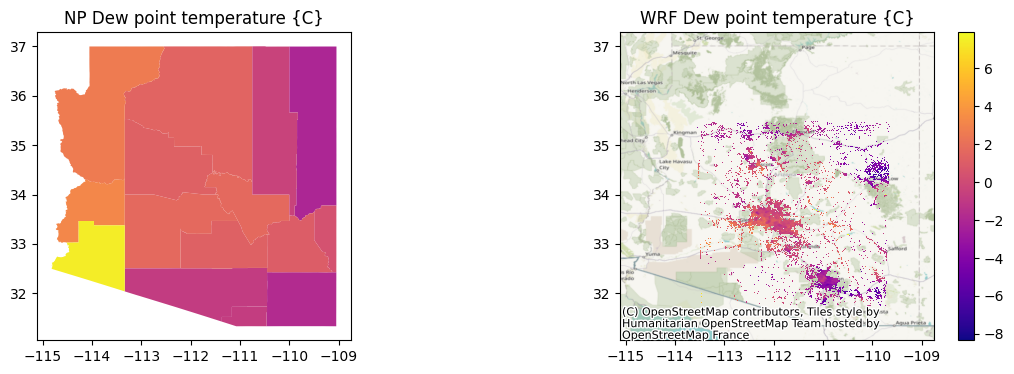

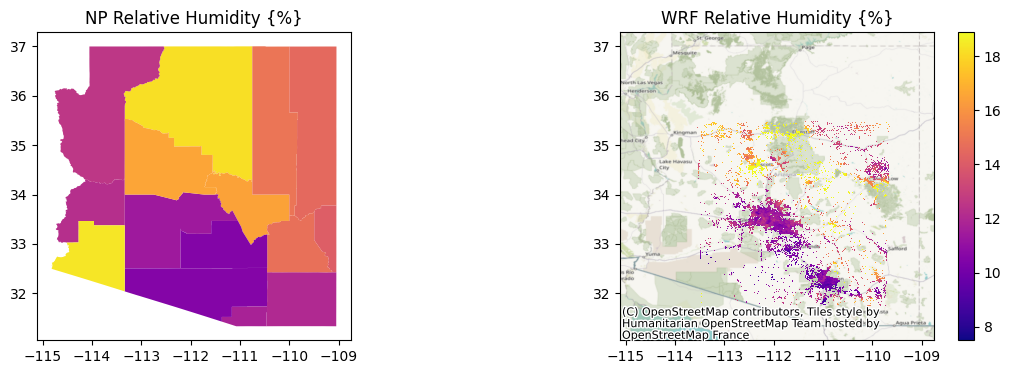

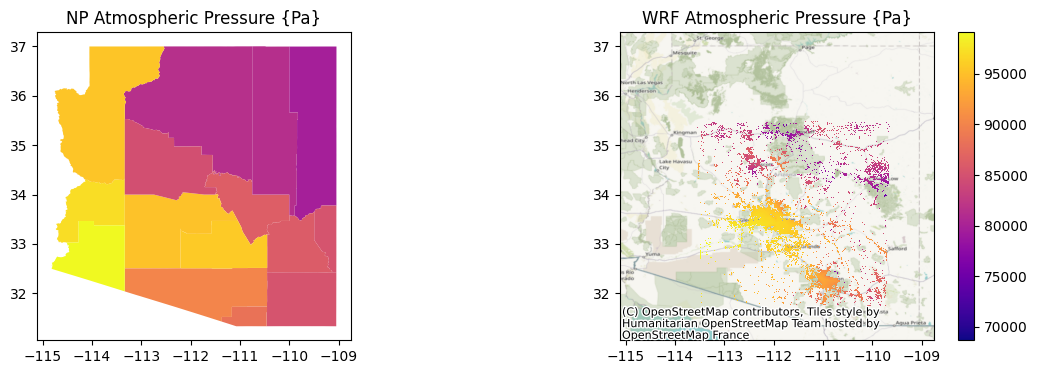

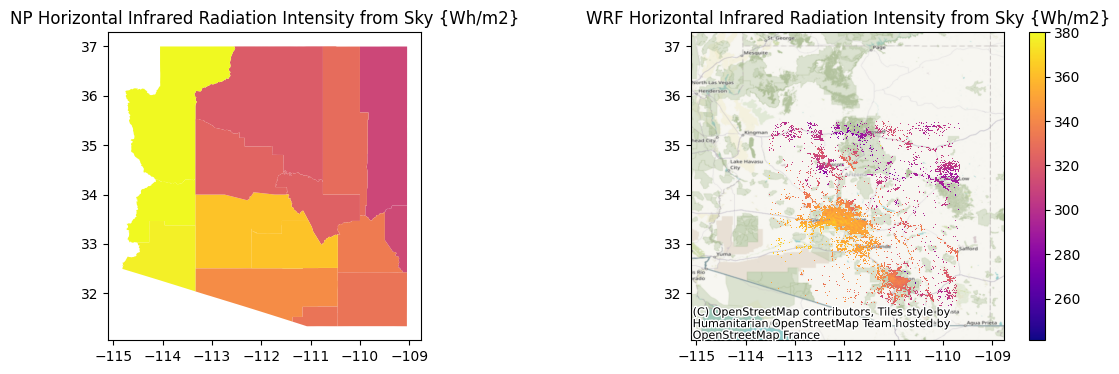

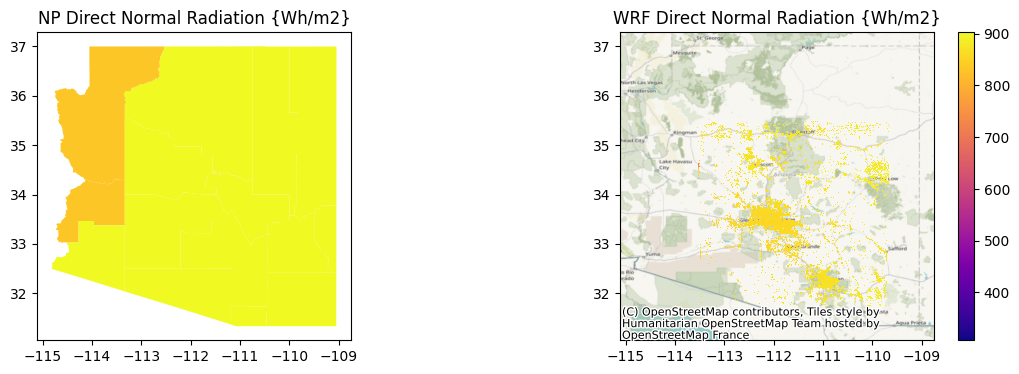

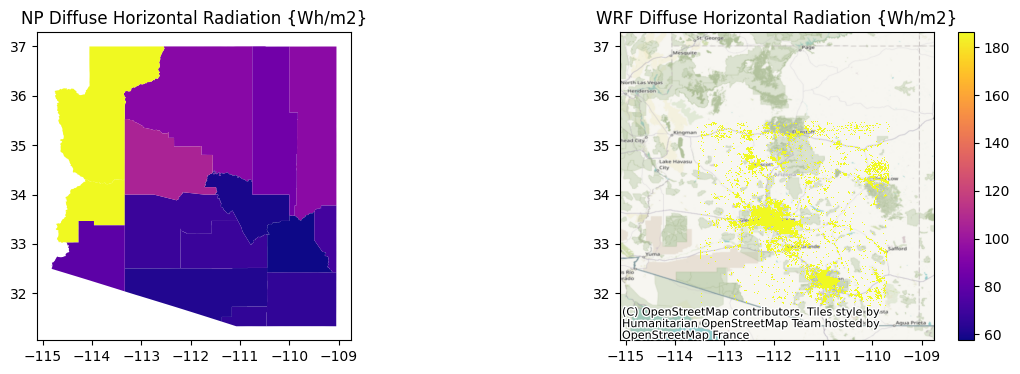

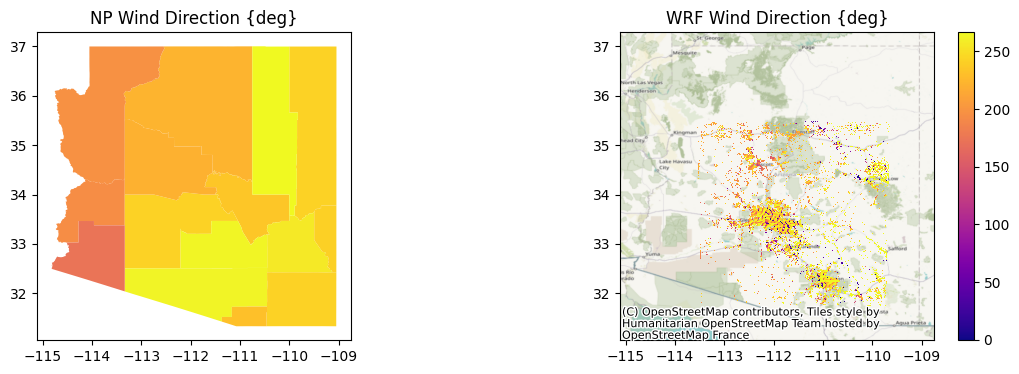

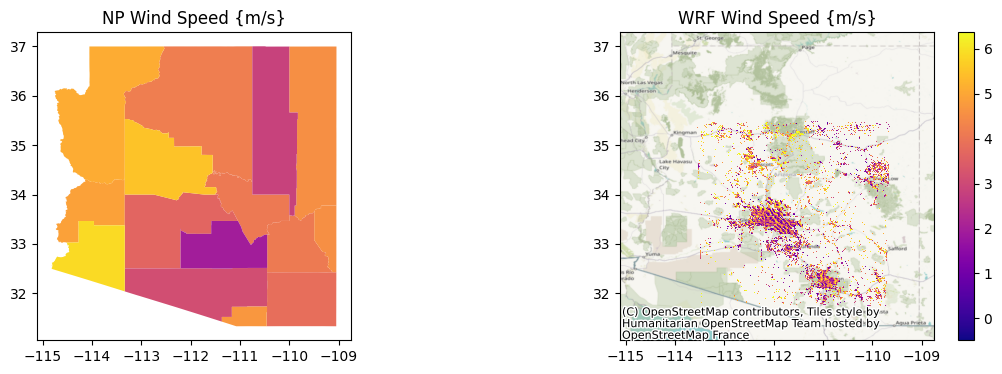

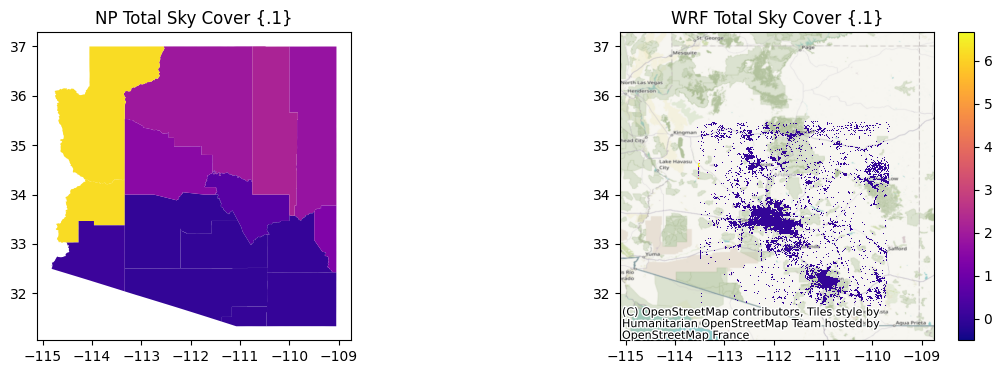

In [26]:
for np_col, wrf_col in zip(np_gdf.columns[5:-1], wrf_gdf.columns[5:-1]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    
    np_plot_data = np_gdf[(np_gdf['Day'] == 16) & (np_gdf['Hour'] == 15)]
    wrf_plot_data = wrf_gdf[(wrf_gdf['Day'] == 16) & (wrf_gdf['Hour'] == 15)]
    
    my_vmin = min(np_plot_data[np_col].min(), wrf_plot_data[wrf_col].min())-.5
    my_vmax = min(np_plot_data[np_col].max(), wrf_plot_data[wrf_col].max())+.5
    
    np_plot_data.plot(ax=ax1, column=np_col, cmap='plasma', vmin=my_vmin, vmax=my_vmax)
    ax1.set_title(f'NP {np_col}')
    
    wrf_plot_data.plot(ax=ax2, legend=True, column=wrf_col, cmap='plasma', vmin=my_vmin, vmax=my_vmax)
    
    ax2.set_title(f'WRF {np_col}')
    ax2.set_xlim(*ax1.get_xlim())
    ax2.set_ylim(*ax1.get_ylim())
    cx.add_basemap(ax2, crs="epsg:4326")
    plt.show()


In [ ]:
wrf_gdf.columns

In [ ]:
np_gdf.columns

In [ ]:
a = counties.loc[counties['NAME'] == 'Maricopa'].geometry
print(a.values[0])

In [ ]:
np_gdf[np_gdf['geometry'] == a.values[0]].plot(column='Dry bulb temperature {C}', legend=True)

In [ ]:
gdf.iloc[0:10, 1] = gdf.iloc[0:10, 1] * .1

In [ ]:
gdf.iloc[0:10, 1]

In [ ]:
wrf_gdf[wrf_gdf.within(bounds)]['Diffuse Ho'].mean()

In [ ]:
np_gdf[np_gdf['geometry'] == a.values[0]]['Diffuse Horizontal Radiation {Wh/m2}'].mean()

In [39]:
np_gdf.columns

Index(['!Year', 'Month', 'Day', 'Hour', 'Minute', 'Dry bulb temperature {C}',
       'Dew point temperature {C}', 'Relative Humidity {%}',
       'Atmospheric Pressure {Pa}',
       'Horizontal Infrared Radiation Intensity from Sky {Wh/m2}',
       'Direct Normal Radiation {Wh/m2}',
       'Diffuse Horizontal Radiation {Wh/m2}', 'Wind Direction {deg}',
       'Wind Speed {m/s}', 'Total Sky Cover {.1}', 'geometry'],
      dtype='object')

In [40]:
np_gdf[np_gdf['geometry'] == a.values[0]]['Dew point temperature {C}'].mean()

-0.4807812500000001

!Year  Month  Day  Hour  Minute  Dry bulb temperature {C}  \
0     2020      5   15    18       0                     21.79   
1     2020      5   15    19       0                     19.76   
2     2020      5   15    20       0                     15.33   
3     2020      5   15    21       0                     13.94   
4     2020      5   15    22       0                     12.94   
..     ...    ...  ...   ...     ...                       ...   
379   2020      5   31    13       0                     35.20   
380   2020      5   31    14       0                     36.27   
381   2020      5   31    15       0                     37.09   
382   2020      5   31    16       0                     37.37   
383   2020      5   31    17       0                     37.00   

     Dew point temperature {C}  Relative Humidity {%}  \
0                        -2.13                  19.94   
1                        -1.10                  24.50   
2                         0.43                  36.12   
3                         0.39                  39.44   
4                         0.31                  41.88   
..                         ...                    ...   
379                       3.50                  13.81   
380                       2.73                  12.25   
381                       2.04                  11.12   
382                       1.41                  10.50   
383                       0.97                  10.38   

     Atmospheric Pressure {Pa}  \
0                      79567.0   
1                      79588.0   
2                      79628.0   
3                      79676.0   
4                      79717.0   
..                         ...   
379                    99284.0   
380                    99207.0   
381                    99120.0   
382                    99040.0   
383                    98987.0   

     Horizontal Infrared Radiation Intensity from Sky {Wh/m2}  \
0                                               290.52          
1                                               283.48          
2                                               278.73          
3                                               275.30          
4                                               271.80          
..                                                 ...          
379                                             378.38          
380                                             384.02          
381                                             384.85          
382                                             388.12          
383                                             381.00          

     Direct Normal Radiation {Wh/m2}  Diffuse Horizontal Radiation {Wh/m2}  \
0                             806.20                                 53.85   
1                             516.34                                 34.46   
2                               0.00                                  0.00   
3                               0.00                                  0.00   
4                               0.00                                  0.00   
..                               ...                                   ...   
379                           938.69                                 83.82   
380                           935.41                                101.87   
381                           946.48                                 88.21   
382                           888.11                                101.91   
383                           861.45                                 85.80   

     Wind Direction {deg}  Wind Speed {m/s}  Total Sky Cover {.1}  \
0                  277.00              6.02                  0.13   
1                  283.36              4.53                  0.06   
2                  291.36              3.24                  0.06   
3                  297.88              3.21                  0.05   
4                  302.34              3.12            

In [29]:
wrf_gdf.columns

Index(['!Year', 'Month', 'Day', 'Hour', 'Minute', 'Dry bulb t', 'Dew point',
       'Relative H', 'Atmospheri', 'Horizontal', 'Direct Nor', 'Diffuse Ho',
       'Wind Direc', 'Wind Speed', 'Total Sky', 'geometry'],
      dtype='object')

In [64]:
gdf.columns

Index(['ID', 'Electricit', 'NaturalGas', 'Heating_El', 'Cooling_El',
       'Heating_Na', 'Heating_To', 'WaterSyste', 'Lighting_E', 'Equipment_',
       'Fans_Elect', 'Pumps_Elec', 'HeatReject', 'HeatRecove', 'Surface_Ou',
       'Zone_Exfil', 'Zone_Exhau', 'Heat_Rejec', 'Anthropoge', 'Electric_1',
       'NaturalG_1', 'Heating__1', 'Cooling__1', 'Heating__2', 'Heating__3',
       'WaterSys_1', 'Lighting_1', 'Equipmen_1', 'Fans_Ele_1', 'Pumps_El_1',
       'HeatReje_1', 'HeatReco_1', 'Surface__1', 'Zone_Exf_1', 'Zone_Exh_1',
       'Heat_Rej_1', 'Anthropo_1', 'geometry'],
      dtype='object')

In [70]:
phx = gdf[gdf.within(bounds)]

In [128]:
phx

ID    Electricit   NaturalGas  Heating_El   Cooling_El  \
402762   8100000749253   5814.395595  1194.972662    0.000000  2154.192559   
402763   8100000803746    411.915915    64.097458    0.000000   226.807088   
402764   8100000779426    637.386114    98.079958    0.000000   324.844550   
402765   8100000817963    711.494635   112.108452    0.000000   353.359669   
402766   8100000846735   3247.612438   663.317273    0.000000  1232.668676   
...                ...           ...          ...         ...          ...   
1490216  8100002313473  18459.856194  2206.299294    0.000000  6684.558407   
1490217  8100002323046  11432.156569    53.001390    0.000000  5790.635403   
1490218  8100002322472   3351.720624   443.848407    0.000000  1628.369323   
1490220  8100002313072  13422.085170   219.132103    0.000000  4926.429048   
1490221  8100002311408  14093.397819   213.247837    3.750572  5525.882630   

         Heating_Na  Heating_To   WaterSyste   Lighting_E   Equipment_  ...  \
402762     0.000000    0.000000   738.039660   332.841907  2001.695452  ...   
402763     9.704434    9.704434    14.395426    14.228412    91.113606  ...   
402764     2.475056    2.475056    34.724481    25.461316   160.147510  ...   
402765     1.359908    1.359908    42.777368    29.616914   185.514585  ...   
402766     0.000000    0.000000   380.463360   183.354023  1111.120958  ...   
...             ...         ...          ...          ...          ...  ...   
1490216    0.000000    0.000000  2988.936412  3189.282213  3695.765938  ...   
1490217   28.499675   28.499675     0.000000  1350.617076  1183.963263  ...   
1490218    5.771646    5.771646   396.051302   116.618575   733.821189  ...   
1490220  171.664967  171.664967     0.000000  2186.682917  1906.898518  ...   
1490221    0.000000    3.750572     0.000000  3273.663224  4574.000386  ...   

          Fans_Ele_1    Pumps_El_1  HeatReje_1  HeatReco_1  Surface__1  \
402762    587.278832  9.029570e-09         0.0         0.0   35.557121   
402763     64.304289  1.761030e-10         0.0         0.0    3.529858   
402764     91.838774  4.248200e-10         0.0         0.0    5.191128   
402765     99.793215  5.233410e-10         0.0         0.0    5.644409   
402766    336.472288  4.654710e-09         0.0         0.0   19.884923   
...              ...           ...         ...         ...         ...   
1490216  1884.137751  4.432537e-08         0.0         0.0   74.585524   
1490217  3085.033856  1.366613e-01         0.0         0.0   21.406624   
1490218   473.589046  5.873369e-09         0.0         0.0   18.863006   
1490220  4068.526014  2.648807e-01         0.0         0.0   29.257680   
1490221  1018.442269  2.726149e-01         0.0         0.0   47.675600   

         Zone_Exf_1  Zone_Exh_1  Heat_Rej_1  Anthropo_1  \
402762    -0.028133         0.0         0.0   35.528987   
402763    -0.033004         0.0         0.0    3.496853   
402764    -0.039418         0.0         0.0    5.151709   
402765    -0.040917         0.0         0.0    5.603492   
402766    -0.054219         0.0         0.0   19.830704   
...             ...         ...         ...         ...   
1490216   -0.465061         0.0         0.0   74.120463   
1490217    0.511961         0.0         0.0   21.918584   
1490218   -0.185545         0.0         0.0   18.677460   
1490220    0.638923         0.0         0.0   29.896603   
1490221   -0.009959         0.0         0.0   47.665641   

                                                  geometry  
402762   POLYGON ((-111.97084 32.80124, -111.97084 32.8...  
402763   POLYGON ((-111.97084 32.80124, -111.97084 32.8...  
402764   POLYGON ((-111.97084 32.80124, -111.97084 32.8...  
402765   POLYGON ((-111.97084 32.80124, -111.97084 32.8...  
402766   POLYGON ((-111.97084 32.80124, -111.97084 32.8...  
...                                                    ...  
1490216  POLYGON ((-112.18333 33.98755, -112.18333 33.9...  
1490217  POLYGON ((-112.18333 33.98755, -112.183

In [81]:
wrf_elec = phx['Electricit']

In [82]:
np_elec = phx['Electric_1']

In [136]:
change = percent_change(wrf_elec, np_elec)
((wrf_elec[change > 0]-np_elec[change > 0]).sum())/np_elec[change > 0].sum()


-0.02553303360903378

In [135]:
((wrf_elec[change < 0]-np_elec[change < 0]).sum())/np_elec[change < 0].sum()


0.028237250001288905

In [95]:
tmp = change.to_frame(name='Change')
_gdf = gpd.GeoDataFrame(tmp, geometry=phx['geometry'])

In [117]:
lower_quantile = _gdf['Change'].quantile(q=.03, interpolation='higher')
upper_quantile = _gdf['Change'].quantile(q=.97, interpolation='lower')
    # cells_gdf[(series > lower_quantile) & (series < upper_quantile)].plot(column=f'{key}_change', ax=ax1, legend=True, norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=lower_quantile, vmax=upper_quantile))


new_gdf = _gdf[(_gdf['Change'] > lower_quantile) & (_gdf['Change'] < upper_quantile)]#.plot(column='Change', legend=True, norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=lower_quantile, vmax=upper_quantile))

In [122]:
new_gdf[new_gdf['Change'] < 0]['Change'].mean()

-3.5056518500325033

In [124]:
len(new_gdf[new_gdf['Change'] < 0].index)

768173

In [125]:
new_gdf[new_gdf['Change'] > 0]['Change'].mean()

2.1029157263265383

In [126]:
len(new_gdf[new_gdf['Change'] > 0].index)

211315

In [145]:
(gdf[gdf.within(bounds)]['Electricit'].sum()-gdf[gdf.within(bounds)]['Electric_1'].sum())/gdf[gdf.within(bounds)]['Electric_1'].sum()


0.00039135418860078604

In [115]:
print(f"{len(cells_gdf[(cells_gdf['Electricity_Facility_change'] > -1) & (cells_gdf['Electricity_Facility_change'] < 1)].index)=}")
print(f"{len(cells_gdf[cells_gdf['Electricity_Facility_change'] < -1].index)=}")
print(f"{len(cells_gdf[cells_gdf['Electricity_Facility_change'] > 1].index)=}")

len(cells_gdf[(cells_gdf['Electricity_Facility_change'] > -1) & (cells_gdf['Electricity_Facility_change'] < 1)].index)=3081
len(cells_gdf[cells_gdf['Electricity_Facility_change'] < -1].index)=10064
len(cells_gdf[cells_gdf['Electricity_Facility_change'] > 1].index)=7524


In [ ]:
cells_gdf[cells_gdf['Electricity_Facility_change'] < 0]['Electricity_Facility_change'].median()